In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [50]:
data = pd.read_csv('train.csv')
df = data.copy()
data_r = pd.read_csv('Riders.csv')
df_r = data_r.copy()
df_merged = pd.merge(df, df_r, how='inner', on='Rider Id')

# Pre-processing

Création des colonnes et préprocessing fait dans l'EDA

In [51]:
numerical_col = df_merged.select_dtypes(include=['int64','float']).columns

categorical_col = df_merged.select_dtypes(exclude=['int64','float']).columns

time_col = ['Pickup - Time', 'Arrival at Pickup - Time', 'Placement - Time',
        'Confirmation - Time', 'Arrival at Destination - Time']
categorical_col = categorical_col.drop(['Order No','User Id', 'Rider Id'])
categorical_col = categorical_col.drop(time_col)
numerical_col = numerical_col.tolist()
categorical_col = categorical_col.tolist()

colToswitch = ['Platform Type',
                'Placement - Weekday (Mo = 1)',
                'Arrival at Pickup - Weekday (Mo = 1)',
               'Confirmation - Weekday (Mo = 1)',
               'Pickup - Weekday (Mo = 1)',
               'Arrival at Destination - Weekday (Mo = 1)',
               ]
categorical_col.extend(colToswitch)
for col in colToswitch:
    numerical_col.remove(col)
numerical_col.remove('Time from Pickup to Arrival')

In [52]:
def transfo_jour(x):
    if x == 1:
        x = str('Monday')
    elif x == 2:
        x = str('Tuesday')
    elif x == 3:
        x = str('Wednesday')
    elif x == 4:
        x = str('Thursday')
    elif x == 5:
        x = str('Friday')
    elif x == 6:
        x = str('Saturday')
    else:
        x = str('Sunday')
    return x

import re
for col in categorical_col:
    if(re.search('Weekday',col)) != None:
       df_merged[col] = df_merged[col].apply(transfo_jour) 

In [53]:
def time_processing(x):
    if isinstance(x, int):
        return x
    else:
        if(x[-2:] == 'AM'):
            varadd = 0
        else:
            varadd = 12
        h, m, s = x[:-3].split(':')
        h = int(h)+varadd
        x = h
        return x
    
for col in time_col:
     df_merged[col] = df_merged[col].apply(time_processing)

In [54]:
listwe = list()
for i in df_merged['Placement - Weekday (Mo = 1)']:
    if i == 'Saturday' or i == 'Sunday':
        listwe.append(True)
    else:
        listwe.append(False)   

In [55]:
df_merged['Weekend'] = listwe
categorical_col.append('Weekend')

In [56]:
time_cat = list()
for index in range(df_merged['Placement - Time'].shape[0]):
    if df_merged['Placement - Time'][index] <= 11:
        time_cat.append("Matin")
    elif df_merged['Placement - Time'][index] > 11 and df_merged['Placement - Time'][index] < 17:
        time_cat.append("Apm")
    elif df_merged['Placement - Time'][index] >= 17 and df_merged['Placement - Time'][index] <= 22:
        time_cat.append("Soiree")
    elif df_merged['Placement - Time'][index] > 22:
        time_cat.append("Nuit")
df_merged['Time cat'] = time_cat
categorical_col.append('Time cat')

On intègre ces valeurs a présent numériques dans les colonnes numériques

In [57]:
for i in range(len(time_col)):
    numerical_col.append(time_col[i])

In [58]:
df_merged.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Weekend,Time cat
0,Order_No_4211,User_Id_633,Bike,3,Business,9,Friday,9,9,Friday,...,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,False,Matin
1,Order_No_27440,User_Id_2642,Bike,3,Personal,18,Friday,15,18,Friday,...,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,False,Apm
2,Order_No_14170,User_Id_3339,Bike,3,Business,31,Friday,24,31,Friday,...,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,False,Nuit
3,Order_No_21727,User_Id_3523,Bike,3,Personal,2,Tuesday,7,2,Tuesday,...,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,False,Matin
4,Order_No_8301,User_Id_87,Bike,2,Personal,22,Tuesday,10,22,Tuesday,...,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,False,Matin


## TrainTest - Nettoyage - Encodage

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_regression

In [60]:
def boolean_process(x):
        if x == True:
            x = 1
        else:
            x = 0
        return x

### Feature engeneering

In [61]:
df_merged['Weekend'] = df_merged['Weekend'].apply(boolean_process)

In [62]:
df_merged['Lat/Long'] = (np.abs(df_merged['Pickup Lat'])-np.abs(df_merged['Destination Lat'])) * (np.abs(df_merged['Pickup Long']) - np.abs(df_merged['Destination Long']))

In [63]:
numerical_col.append(['Lat/Long'])

In [64]:
print(mutual_info_regression(df_merged['Lat/Long'].to_numpy().reshape(-1,1), df_merged['Time from Pickup to Arrival']))
print(mutual_info_regression(df_merged['Distance (KM)'].to_numpy().reshape(-1,1), df_merged['Time from Pickup to Arrival']))

[0.26528257]
[0.29126856]


On peut également créer une feature via les K-Means-Clustering

In [65]:
features = ["Distance (KM)", 'Lat/Long']

In [66]:
from sklearn.cluster import KMeans
distortion = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_merged[features])
    distortion.append(kmeans.inertia_)

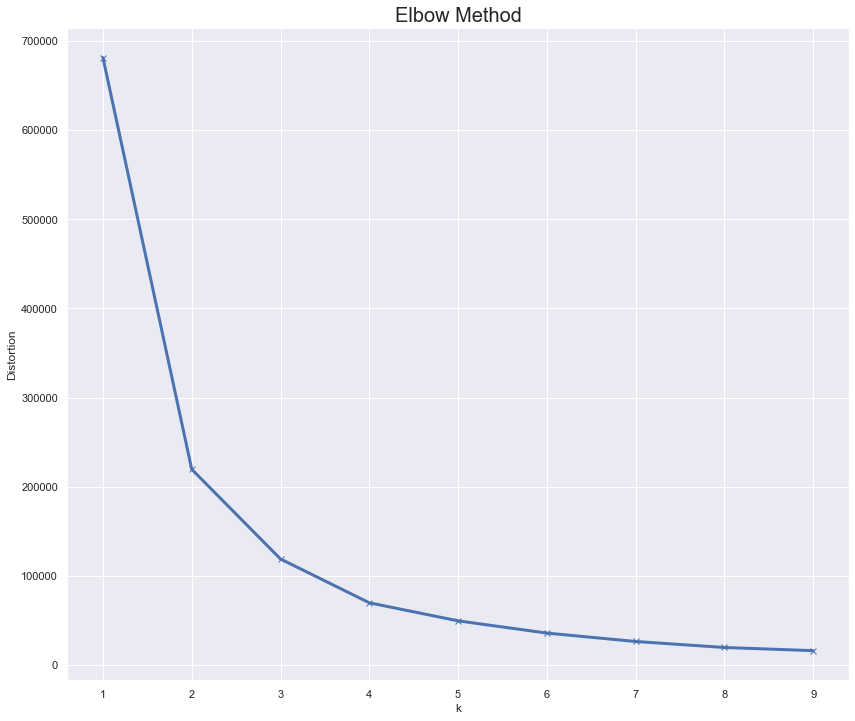

In [67]:
plt.figure(figsize=(14,12))
plt.plot(K, distortion, 'bx-' , linewidth = 3)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method', fontsize = 20)
plt.show()

In [68]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_merged[features])
df_merged['KMeans Label'] = kmeans.labels_.tolist()

Baisse très légèrement la précision du modèle.

### Train_set / Test_test

In [69]:
train_set, test_set = train_test_split(df_merged, test_size=0.2, random_state=0)

La variable Lat/Long définie au dessus semble avoir une information mutuelle presque identique à distance par rapport à la target. Pourtant, la précision des modèles augmente très peu en intégrant cette variable (pourquoi ?)

### Fonctions de préprocessing

In [70]:
from sklearn.impute import KNNImputer

In [71]:
def imputer(df):
    df = df.drop('Precipitation in millimeters', axis = 1)
    imputer = KNNImputer(missing_values = np.nan, n_neighbors = 5)
    df['Temperature'] = imputer.fit_transform(df['Temperature'].to_numpy().reshape(-1,1))
    return df

In [72]:
def preprocessing(df):
    df = imputer(df)
    X = df.drop('Time from Pickup to Arrival', axis = 1)
    y = df['Time from Pickup to Arrival']
    return X, y

In [73]:
numerical_col.append(['Temperature'])

### Pipelines de préprocessing

In [74]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import PolynomialFeatures

In [75]:
categorical_pip = make_pipeline(OneHotEncoder())
boolean_pip = make_pipeline(OneHotEncoder(categories = 'auto'))
numerical_pip_scaled = make_pipeline(StandardScaler(), PolynomialFeatures(2), SelectKBest(mutual_info_regression, k = "all"))

In [76]:
process_pip_scaled = make_column_transformer((categorical_pip, ['Time cat', 'Personal or Business',
                                                                'Platform Type']),
                                      (boolean_pip, ['Weekend']),
                                      (numerical_pip_scaled, ['Distance (KM)', 'Lat/Long']),
                                      remainder = "drop")

## Modelisation pour évaluer l'efficacité du préprocessing

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [78]:
model_1 = make_pipeline(process_pip_scaled, DecisionTreeRegressor(random_state = 0))

In [79]:
model_2 = make_pipeline(process_pip_scaled, LinearRegression())

In [80]:
X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)

## Evaluation

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import learning_curve

In [84]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print('MAE :', mean_absolute_error(y_test, ypred)/60)
    print('RMSE :', np.sqrt(mean_squared_error(y_test, ypred)/60))
    print('Median Absolute Error :', median_absolute_error(y_test, ypred)/60)
    print('R2 :', r2_score(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(14, 12))
    plt.plot(N, train_score.mean(axis=1), label='train score', linewidth = 3)
    plt.plot(N, val_score.mean(axis=1), label='validation score', linewidth = 3)
    plt.ylabel('R2', fontsize = 15)
    plt.legend()
    plt.show()

MAE : 9.112615194922581
RMSE : 102.75188825264947
Median Absolute Error : 6.222916666666666
R2 : 0.3472343654068507


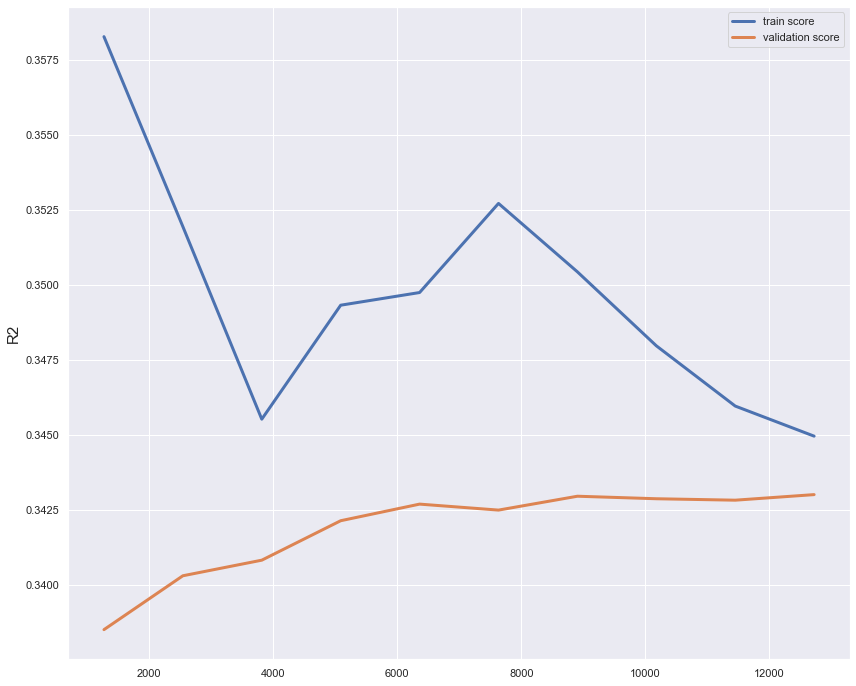

In [85]:
evaluation(model_2)

<ul>
    <li> Distance est la seule variable réellement apportant de l'information sur la target. </li>
    <li> En intégrant weekend et les variables qualitatives au modèle, notre modèle est un peu meilleur </li>
    <li> Température avec un KNNImputer et 5 voisins fait baiser lui la précision du modèle. </li>
</ul>